# Установка зависимостей

In [ ]:
!pip install librosa numpy tqdm

In [ ]:
# Загрузка аудиофайлов и натренированных моделей
!gdown https://drive.google.com/uc?id=1hiZcoW1cXt62MTah1quxE7GpmO7koPuY
!gdown https://drive.google.com/uc?id=1cUQook4cFwOl-TdlEIxnZYE5AaCnFQjD
!gdown https://drive.google.com/uc?id=1pwiA4txd7OauxZATCprKEqGd1z519I7C
!gdown https://drive.google.com/uc?id=1BLj0eq85kTZmN-h0wvsONBkwQpuEQgXG
!gdown https://drive.google.com/uc?id=1MplVH6yVCcGH4hXTD0-0v8XnV19yHSN2
!gdown https://drive.google.com/uc?id=1DPDA13NZVwDLRdb14In8is9ugD7Jg4XD
!gdown https://drive.google.com/uc?id=1_Gt7YnywmAqlWKD_zncTbBPTrkGAUoM_
!gdown https://drive.google.com/uc?id=1PPrH-wJ_Bk14I91ddBxfkaZ8FOyUBuJx

Downloading...
From (original): https://drive.google.com/uc?id=1hiZcoW1cXt62MTah1quxE7GpmO7koPuY
From (redirected): https://drive.google.com/uc?id=1hiZcoW1cXt62MTah1quxE7GpmO7koPuY&confirm=t&uuid=8ceca836-a415-48de-968f-1ec75c9e4600
To: /content/test_x.zip
100% 27.8M/27.8M [00:00<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cUQook4cFwOl-TdlEIxnZYE5AaCnFQjD
To: /content/test_y.zip
100% 10.7M/10.7M [00:00<00:00, 35.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pwiA4txd7OauxZATCprKEqGd1z519I7C
From (redirected): https://drive.google.com/uc?id=1pwiA4txd7OauxZATCprKEqGd1z519I7C&confirm=t&uuid=86e4792d-1c95-4002-b3d4-f03ef9239cba
To: /content/train_x.zip
100% 88.7M/88.7M [00:01<00:00, 49.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1BLj0eq85kTZmN-h0wvsONBkwQpuEQgXG
From (redirected): https://drive.google.com/uc?id=1BLj0eq85kTZmN-h0wvsONBkwQpuEQgXG&confirm=t&uuid=1867da79-7d56-4884-8ea8-e4ad30d8ff41
To: /content/train_

In [ ]:
# Распаковка архивов
!unzip train_x &> /dev/null
!unzip train_y &> /dev/null
!unzip test_x &> /dev/null
!unzip test_y &> /dev/null
!unzip valid_x &> /dev/null
!unzip valid_y &> /dev/null
!unzip models &> /dev/null

In [ ]:
# Загрузка noise_utils
!pip install git+https://github.com/vladimirch-afk/noise_utils.git

  Cloning https://github.com/vladimirch-afk/noise_utils.git to /tmp/pip-req-build-ce8alccv
  Running command git clone --filter=blob:none --quiet https://github.com/vladimirch-afk/noise_utils.git /tmp/pip-req-build-ce8alccv
  Resolved https://github.com/vladimirch-afk/noise_utils.git to commit 290338d2fb9b5f7bdd9734be28aeff6caa7e0c20
  Preparing metadata (setup.py) ... done
  Created wheel for noise-utils: filename=noise_utils-0.0.10-py3-none-any.whl size=4133 sha256=342ae075d6f30d203ef55292d65c563b6831f1dd38cf139c9e5921abb05190c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wspxnr_5/wheels/aa/99/4b/15da170997d26161b173dbfe80a7c92273af44a9392157d9a4
Successfully built noise-utils


In [ ]:
import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import soundfile as sf
import tensorflow as tf
from perlin_noise import PerlinNoise
from tqdm import tqdm
from tqdm.keras import TqdmCallback
# Собственная библиотека
from noise_utils import Noisemaker, SignalGenerator, DataPreparator
from tensorflow.keras import layers, models

# Добавление шума

При помощи данного блока кода можно сгенерировать зашумленный датасет из файлов с чистым звуком.

50it [16:29, 19.78s/it]


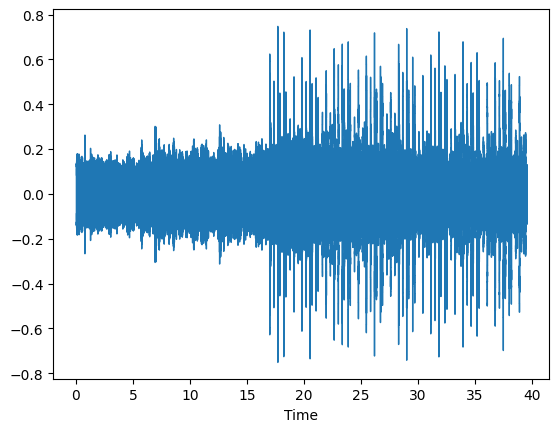

In [ ]:
"""
выполняется долго, готовые файлы есть в train_y
"""
# Названия директорий с чистыми и зашумленными данными
clean_audio_files = "train_x"
noisy_audio_files = "train_y"

preparer = DataPreparator() # Класс для подготовки данных
# X - зашумленный звук, y - чистый звук
X, y, sr = preparer.generate_noised_audios(clean_audio_files, noisy_audio_files, Noisemaker().add_perlin_noise)
librosa.display.waveshow(np.array(X[0]).flatten(), sr=sr)

# Загрузка данных

In [ ]:
# Пути к файлам с чистым и зашумленным звуком
clean_audio_files = "train_x"
noisy_audio_files = "train_y"
val_x_dir = "valid_x"
val_y_dir = "valid_y"
test_x_dir = "test_x"
test_y_dir = "test_y"

window_size = 1000 # Размер обрабытываемого окна

# Создать объект для предварительной обработки данных
preparer = DataPreparator()

# Загрузить данные из каталогов
train_x, _, sr = preparer.load_files_from_directory(clean_audio_files)
train_y, _, sr = preparer.load_files_from_directory(noisy_audio_files)

val_x, _, sr = preparer.load_files_from_directory(val_x_dir)
val_y, _, sr = preparer.load_files_from_directory(val_y_dir)

test_x, _, sr = preparer.load_files_from_directory(test_x_dir)
test_y, _, sr = preparer.load_files_from_directory(test_y_dir)

# Измененить размерности данных для соответствия оконному размеру
train_x = preparer.reshape_data(train_x, window_size)
train_y = preparer.reshape_data(train_y, window_size)
val_x = preparer.reshape_data(val_x, window_size)
val_y = preparer.reshape_data(val_y, window_size)
test_x = preparer.reshape_data(test_x, window_size)
test_y = preparer.reshape_data(test_y, window_size)

# Шумоочистка при помощи сверточного автоэнкодера

Автоэнкодеры (автокодировщики) - это тип нейронных сетей, построенные на принципе сжатия данных в летентное пространство и дальнейшего восстановления данных. Основная идея состоит в том, чтобы представить данные в сжатой форме в скрытом слое (или слоях) латентного пространства, а затем использовать декодер для восстановления оригинальных данных из этого сжатого представления. В результате автоэнкодеры выучивают наиболее важные признаки и закономерности (которые запоминаются в латентном пространстве) в данных, что позволяет им эффективно удалять шум и восстанавливать чистые данные. \\



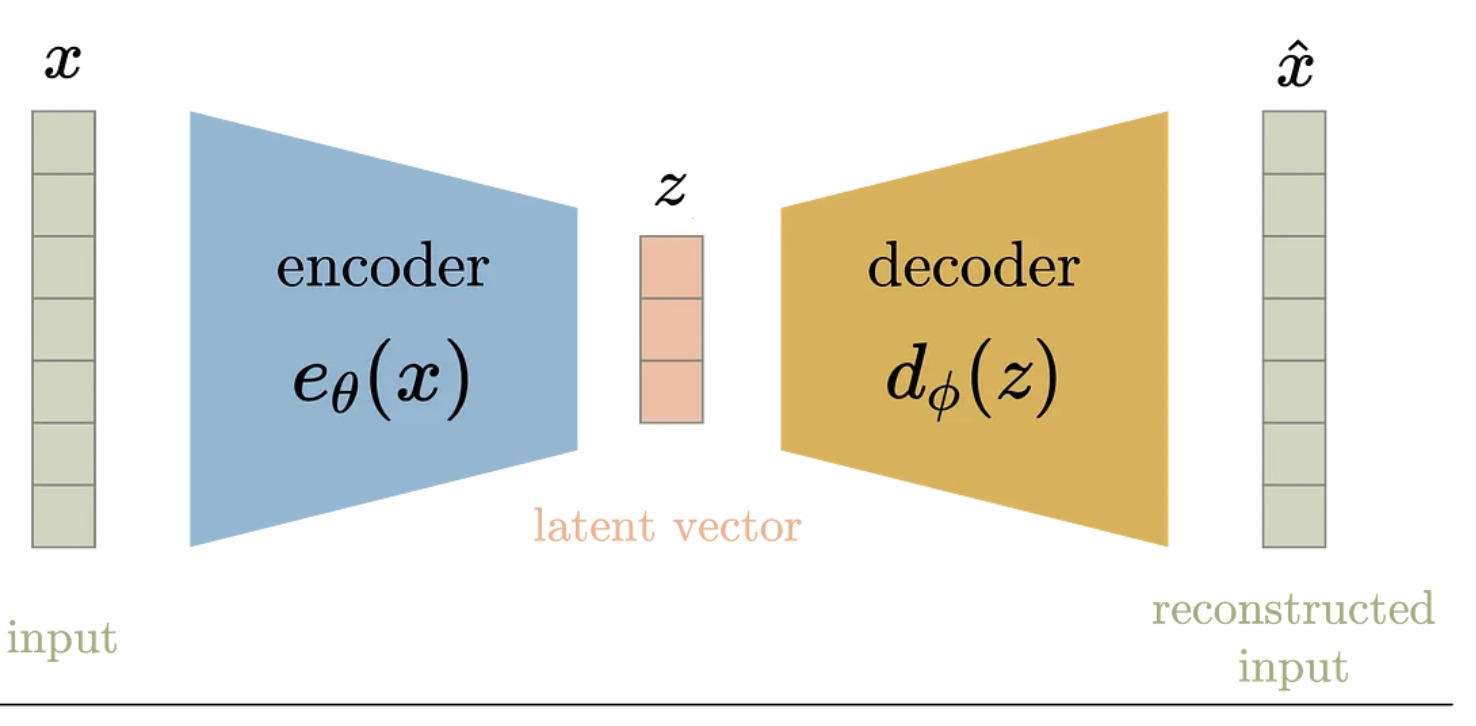

Основные составляющие автоэнкодера:
1. Энкодер
- Входной слой принимает исходные данные в их первоначальном виде.
- Скрытые слои последовательно уменьшают размерность входных данных, захватывая важные признаки и закономерности. Эти слои составляют энкодер.
2. Латентное пространство
- Латентное пространство является последним скрытым слоем, где размерность уменьшается. Этот слой представляет собой сжатое кодирование входных данных. \\
3. Декодер
- Сверточные слои последовательно увеличивают размерность до изначальной и стремятся восстановить исходные данные (в контексте шумоочистки это чистый сигнал).
---
Во время обучения автоэнкодер учится минимизировать функцию потерь между эталонным чистым аудио (если рассматривать в контексте шумоочистки звука) и выводом сети.

Рассмотрим ниже возможную реализацию сверточного автоэнкодера.

In [ ]:
"""
Шумоочистка при помощи сверточного автоэнкодера
"""
# Создать сверточную сеть
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        # Энкодер
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        # Летнтное пространство
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        # Декодер
        layers.UpSampling1D(size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(1, kernel_size=3, activation='tanh', padding='same')
    ])
    return model


# Определенить форму входных данных для модели
input_shape = (window_size, 1)

# Созданить модель для шумоочистки
model = create_noise_canceling_model(input_shape)

# Скомпилировать и обучить модель
model.compile(optimizer='adam', loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=20,
          batch_size=128,
          callbacks=[TqdmCallback(verbose=1)],
          validation_data=(val_x, val_y),
          verbose=0)

# Сохранить обученную модель
model.save("noise_cancel_conv.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 125, 128)          0

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

Чтобы не ждать обучения сети, можно загрузить заранее натренированную модель.

In [ ]:
model = keras.saving.load_model("models/noise_cancel_conv.h5")

Посмотрим значение функции потерь на тестовых данных.

In [ ]:
display(model.evaluate(test_x, test_y))

188/188 [==============================] - 12s 59ms/step - loss: 0.0011


0.0010995211778208613

Посмотрим, как сеть очистит 1 зашумленный файл

26/26 [==============================] - 2s 48ms/step


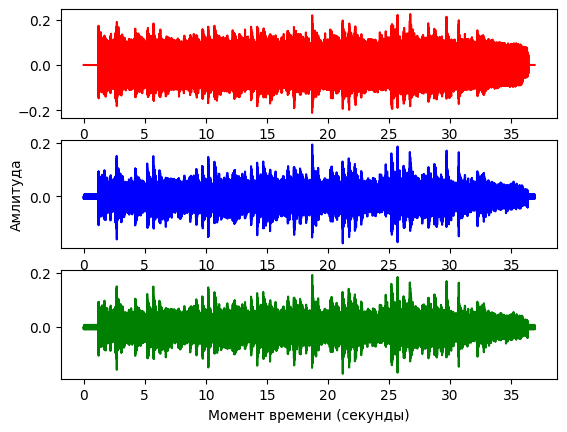

In [ ]:
preparer = DataPreparator()

# Размер окна для обработки аудио
window_size = 1000

# Загрузить зашумленный аудиофайл
noisy_audio, sr = preparer.load_file("music.wav")

# Изменить форму данных, чтобы они соответствовали ожидаемому формату модели
noisy_audio = preparer.reshape_data([noisy_audio])
noisy_audio = np.array(noisy_audio).reshape(-1, window_size, 1)

# Предсказать чистый звук с помощью модели
clean_audio = model.predict(noisy_audio).flatten()

# Сохранить предсказанный чистый аудиофайл
output_file = "clean_audio_conv.wav"
preparer.save_audio(clean_audio, output_file, sr)

# Преобразовать зашумленный и чистый аудиофайлы в одномерные массивы
X = noisy_audio.flatten()
y = clean_audio.flatten()

# Построить графики для зашумленного, чистого и очищенного аудиофайлов
lin_space = np.linspace(0, clean_audio.shape[0] / sr, clean_audio.shape[0])
fig, axs = plt.subplots(3)
axs[1].set_ylabel("Амлитуда")
axs[2].set_xlabel("Момент времени (секунды)")
axs[0].plot(lin_space, X, color='r')  # Красный - зашумленный
axs[1].plot(lin_space, clean_audio, color='b')  # Синий - чистый
axs[2].plot(lin_space, y, color='g')  # Зеленый - очищенный
plt.show()

# Шумоочистка при помощи LSTM


LSTM (Long Short-Term Memory)-сети - тип рекуррентных нейронных сетей, способный генерировать очередной вывод, учитывая предыдущие вводы/выводы сети. LSTM отличается от многих других рекуррентных нейронных сетей тем, что способен эффективно обрабатывать и запоминать долгосрочные зависимости в последовательностях данных, что делает их довольно популярными в генерации последовательностей в целом. В контексте шумоочистки, LSTM-сети обучаются на зашумленных входных данных и стремятся восстановить чистые данные. Они способны учитывать контекст и долгосрочные зависимости между данными, что делает их эффективными инструментами для решения задачи удаления шума из временных последовательностей.

Рассмотрим пример реализации LSTM-сети для шумоочистки звукового сигнала

In [ ]:
"""
Шумоочистка при помощи LSTM
"""

# Создать LSTM-сеть
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.TimeDistributed(layers.Dense(64)),
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.TimeDistributed(layers.Dense(1)),
    ])
    return model


# Определение формы входных данных для модели
input_shape = (window_size, 1)

# Создать модель LSTM для шумоочистки
model = create_noise_canceling_model(input_shape)

# Скомпилировать и обучить модель
model.compile(optimizer='adam', loss='mse')
print(model.summary())
model.fit(train_x, train_y, epochs=20, batch_size=32, callbacks=[TqdmCallback(verbose=1)], verbose=0)

# Сохранение обученной модели
model.save("noise_cancel_lstm.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 time_distributed (TimeDist  (None, 1000, 64)          4160      
 ributed)                                                        
                                                                 
 lstm_2 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 time_distributed_1 (TimeDi  (None, 1000, 1)           65        
 stributed)                                           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

Загружаем заранее натренированную модель, чтобы не ждать окончание обучения.

In [ ]:
model = keras.saving.load_model("models/noise_cancel_lstm.h5")

Посмотрим на значение функции ошибки на тестовых данных.

In [ ]:
display(model.evaluate(test_x, test_y))

188/188 [==============================] - 107s 559ms/step - loss: 0.0016


0.0015806874725967646

Посмотрим на примере одного зашумленного файла, как сеть справится с удалением шума.

26/26 [==============================] - 16s 525ms/step


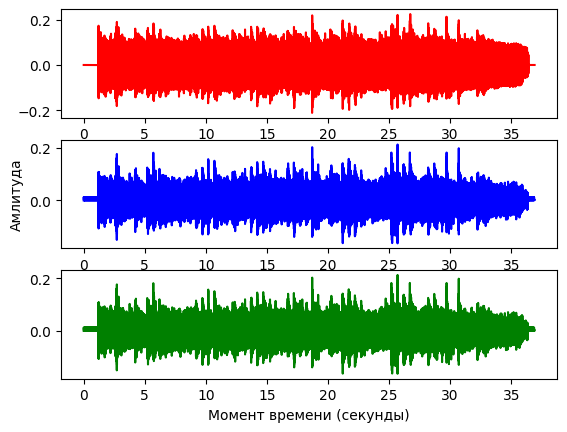

In [ ]:
# Создать экземпляр класса DataPreparator для предварительной обработки данных
preparer = DataPreparator()

# Определить размер окна для обработки аудио
window_size = 1000

# Загрузить зашумленный аудиофайл
noisy_audio, sr = preparer.load_file("music.wav")

# Изменить форму данных, чтобы они соответствовали ожидаемому формату модели
noisy_audio = preparer.reshape_data([noisy_audio])
noisy_audio = np.array(noisy_audio).reshape(-1, window_size, 1)

# Предсказать чистый звук с помощью модели LSTM
clean_audio = model.predict(noisy_audio).flatten()

# Сохранить предсказанный чистый аудиофайл
output_file = "clean_audio_lstm.wav"
preparer.save_audio(clean_audio, output_file, sr)

# Преобразовать зашумленный и чистый аудиофайлы в одномерные массивы
X = noisy_audio.flatten()
y = clean_audio.flatten()

# Построить графики для зашумленного, чистого и очищенного аудиофайлов
lin_space = np.linspace(0, clean_audio.shape[0] / sr, clean_audio.shape[0])
fig, axs = plt.subplots(3)
axs[1].set_ylabel("Амлитуда")
axs[2].set_xlabel("Момент времени (секунды)")
axs[0].plot(lin_space, X, color='r')  # Красный - зашумленный
axs[1].plot(lin_space, clean_audio, color='b')  # Синий - чистый
axs[2].plot(lin_space, y, color='g')  # Зеленый - очищенный
plt.show()


# Задание

Реализуйте свою собственную нейросетевую модель для шумоочистки.

## Возможное решение

In [ ]:
# Создать сеть
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(1, kernel_size=3, activation='tanh', padding='same')
    ])
    return model


# Определение формы входных данных для модели
input_shape = (window_size, 1)

# Создать модель LSTM для шумоочистки
model = create_noise_canceling_model(input_shape)

# Скомпилировать и обучить модель
model.compile(optimizer='adam', loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=20,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          verbose=0)

# Сохранение обученной модели
model.save("hw_nn.h5")